In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [4]:
num_experiments = 100
parameter_list = ['gamma', 'gradnoise']

In [5]:
file_names = ["gradient_latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["gradient_latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [6]:
X = get_parameter_array(file_names,parameter_list)

In [7]:
Y = get_rewards(data_files, average_function_over_time(average_distance_between_cells))

In [8]:
lowest_dist = np.argmin(Y)
print(lowest_dist) 
print(np.min(Y))
# matches the gradient-based adherence

34
38.835756462210185


In [9]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction



In [10]:
kernel = GPy.kern.RBF(input_dim=2, ARD=True, lengthscale=[1,1], variance=1)
model_gpy = GPRegression(X, Y ,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

In [11]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


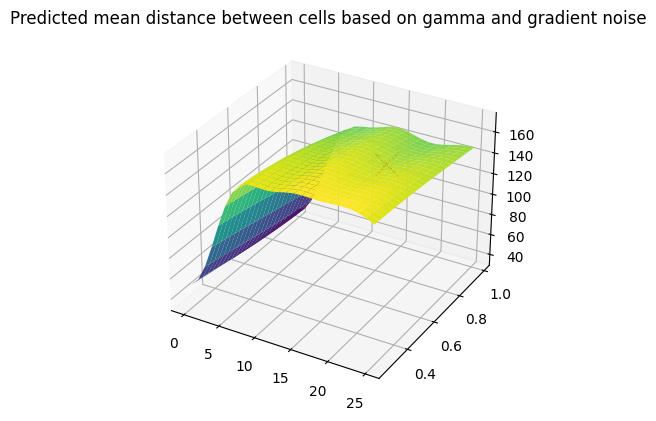

In [12]:
parameter_space = ParameterSpace([
                                DiscreteParameter('gamma',list(range(0,25))),
                                ContinuousParameter('gradnoise',0.25,0.99)])

_gamma_test = np.linspace(0, 25, 25)
_gradnoise_test = np.linspace(0.25, 0.99, 25)

coords_gamma, coords_gradnoise = np.meshgrid(_gamma_test, _gradnoise_test)

_mean, _var = model_emukit.predict(np.c_[coords_gamma.ravel(), coords_gradnoise.ravel()])

reshaped_mean = _mean.reshape(coords_gamma.shape)


ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Predicted mean distance between cells based on gamma and gradient noise')
ax.scatter(model_emukit.X[0][0], model_emukit.X[0][1], model_emukit.Y[0], color='red', s=300, marker='x')

Text(0.5, 0.92, 'Predicted mean distance between cells based on gamma and gradient noise')

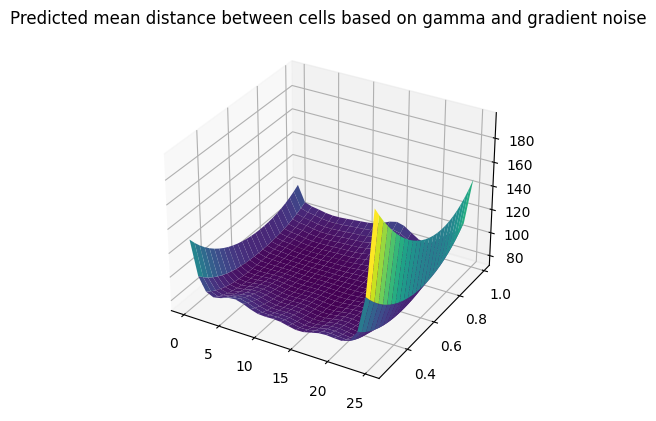

In [13]:
reshaped_var = _var.reshape(coords_gamma.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_var, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Predicted mean distance between cells based on gamma and gradient noise')

In [14]:
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
center_of_mass_sa_gpbased = MonteCarloSensitivity(model = model_emukit, input_domain = parameter_space)

main_effects_gp, total_effects_gp, _ = center_of_mass_sa_gpbased.compute_effects(num_monte_carlo_points = 10000)

print(main_effects_gp)
print(total_effects_gp)

{'gamma': array([0.95908715]), 'gradnoise': array([0.05467277])}
{'gamma': array([0.95577532]), 'gradnoise': array([0.00938575])}


(0.05467276955139738, 0.009385747726389268)


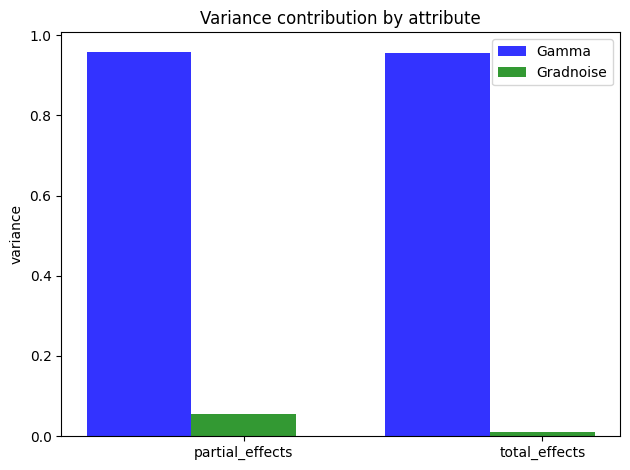

In [15]:
n_groups = 2
means_frank = (main_effects_gp['gamma'][0], total_effects_gp['gamma'][0] )
means_guido = (main_effects_gp['gradnoise'][0], total_effects_gp['gradnoise'][0])
print(means_guido)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
alpha=opacity,
color='b',
label='Gamma')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='g',
label='Gradnoise')

# plt.xlabel('Variance groups')
plt.ylabel('variance')
plt.title('Variance contribution by attribute')
plt.xticks(index + bar_width, ('partial_effects', 'total_effects'))
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
Y = get_rewards(data_files, function_at_last_time(distance_to_peak_gradient))


In [17]:
# print(Y)
# print(np.argmin(Y))
print(np.min(Y))
print(np.argmin(Y))

57.84468693610938
72


In [18]:
kernel = GPy.kern.RBF(input_dim=2, ARD=True, lengthscale=[1,1], variance=1)
model_gpy = GPRegression(X, Y ,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

Text(0.5, 0.92, 'Mean distance between peak gradient and the center of mass across a population of N=100 cells')

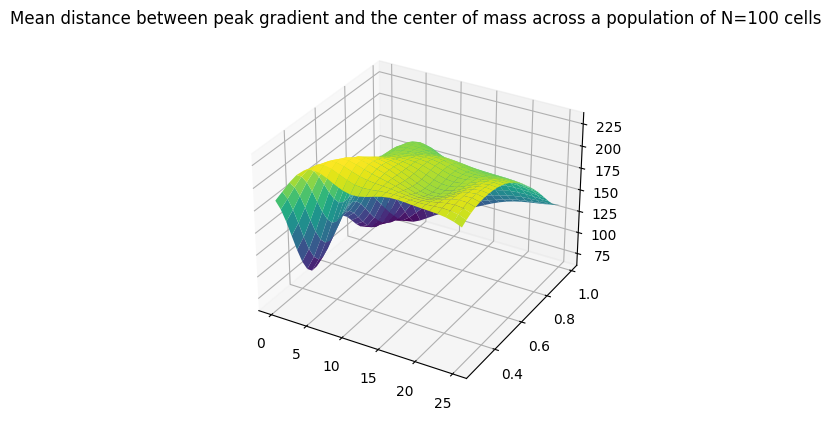

In [19]:
parameter_space = ParameterSpace([
                                DiscreteParameter('gamma',list(range(0,25))),
                                ContinuousParameter('gradnoise',0.25,0.99)])

_gamma_test = np.linspace(0, 25, 25)
_gradnoise_test = np.linspace(0.25, 0.99, 25)

coords_gamma, coords_gradnoise = np.meshgrid(_gamma_test, _gradnoise_test)


_mean, _var = model_emukit.predict(np.c_[coords_gamma.ravel(), coords_gradnoise.ravel()])

reshaped_mean = _mean.reshape(coords_gamma.shape)


ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Mean distance between peak gradient and the center of mass across a population of N=100 cells')

Text(0.5, 0.92, 'Distance between peak gradient and the center of mass across a population of N=100 cells')

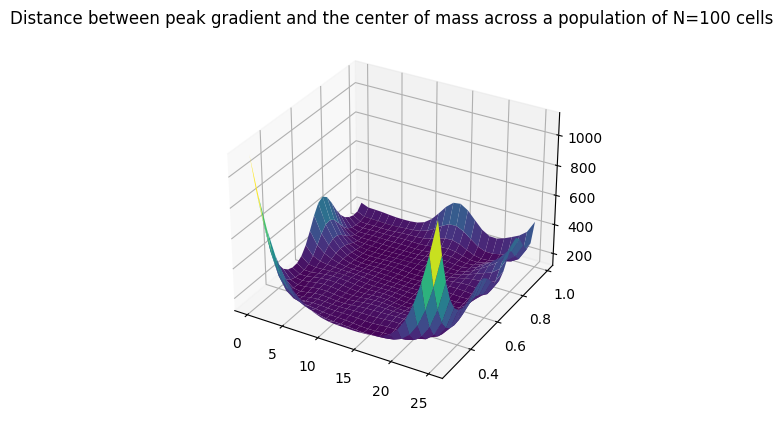

In [20]:
reshaped_var = _var.reshape(coords_gamma.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_var, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Distance between peak gradient and the center of mass across a population of N=100 cells')

In [21]:
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
center_of_mass_sa_gpbased = MonteCarloSensitivity(model = model_emukit, input_domain = parameter_space)

main_effects_gp, total_effects_gp, _ = center_of_mass_sa_gpbased.compute_effects(num_monte_carlo_points = 10000)

print(main_effects_gp)
print(total_effects_gp)

{'gamma': array([0.44858474]), 'gradnoise': array([0.42735665])}
{'gamma': array([0.61650429]), 'gradnoise': array([0.62617217])}


(0.4273566511524938, 0.6261721678296293)


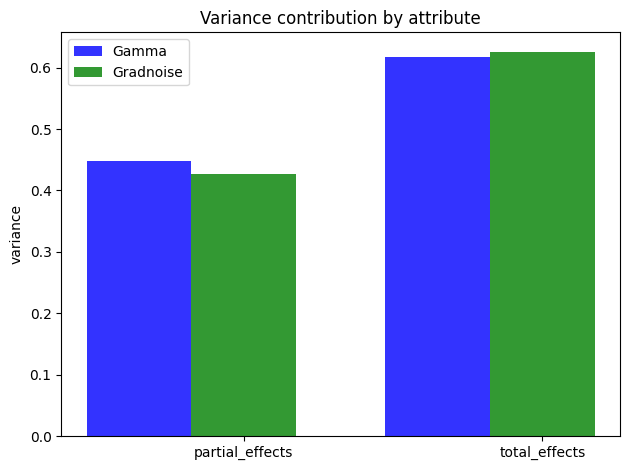

In [22]:
n_groups = 2
means_frank = (main_effects_gp['gamma'][0], total_effects_gp['gamma'][0] )
means_guido = (main_effects_gp['gradnoise'][0], total_effects_gp['gradnoise'][0])
print(means_guido)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
alpha=opacity,
color='b',
label='Gamma')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='g',
label='Gradnoise')

# plt.xlabel('Variance groups')
plt.ylabel('variance')
plt.title('Variance contribution by attribute')
plt.xticks(index + bar_width, ('partial_effects', 'total_effects'))
plt.legend()

plt.tight_layout()
plt.show()